In [2]:
# Change the current working directory to the repo root.
# It makes the relative imports easier
import os
from pathlib import Path
from git import Repo
repo = Repo(Path().resolve(), search_parent_directories=True)
project_root = Path(repo.git.rev_parse("--show-toplevel"))
os.chdir(project_root)

# Gomoku Prediction
MVP for counterfactual prediction of the Gomoku games

In [56]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI
import json
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

from simulations.gomoku import board_visual

client = OpenAI()

In [4]:
with open('data/gomoku/_train.pkl', 'rb') as f:
    train = pickle.load(f)

with open('data/gomoku/_test.pkl', 'rb') as f:
    test = pickle.load(f)

In [17]:
def split_test_run(run):
    observable, alternative = run[0], run[1]
    for i, event in enumerate(observable):
        if event != alternative[i]:
            start = observable[:i]
            A = observable[i:]
            B = alternative[i:]
            break
    return start, A, B

In [18]:
start, A, B = split_test_run(test[0])

In [32]:
def apply_events(game_board: np.array, events: list):
    board = game_board.copy()
    for event in events:
        if isinstance(event, str):
            continue
        board[event.row, event.col] = event.stone
    return board

In [33]:
game_board = np.zeros((7, 7), dtype=int)
game_board

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [35]:
def events_to_msg(events, visualize_each=5):
    msg = []
    board = np.zeros((7, 7), dtype=int)
    for i, event in enumerate(events):
        if i % visualize_each == 0:
            msg.append(board_visual(board))
        board = apply_events(board, [event])
        msg.append(event.__repr__())
    msg.append(board_visual(board))
    return "\n".join(msg)

In [37]:
print(events_to_msg(start))

   A B C D E F G
A  . . . . . . .
B  . . . . . . .
C  . . . . . . .
D  . . . . . . .
E  . . . . . . .
F  . . . . . . .
G  . . . . . . .
GameEvent(row=5, col=3, stone=3)
GameEvent(row=5, col=4, stone=3)
GameEvent(row=3, col=5, stone=3)
GameEvent(row=4, col=1, stone=3)
GameEvent(row=1, col=6, stone=1)
   A B C D E F G
A  . . . . . . .
B  . . . . . . X
C  . . . . . . .
D  . . . . . * .
E  . * . . . . .
F  . . . * * . .
G  . . . . . . .
GameEvent(row=3, col=4, stone=2)
GameEvent(row=1, col=4, stone=1)
GameEvent(row=3, col=3, stone=2)
GameEvent(row=3, col=6, stone=1)
GameEvent(row=2, col=6, stone=2)
   A B C D E F G
A  . . . . . . .
B  . . . . X . X
C  . . . . . . O
D  . . . O O * X
E  . * . . . . .
F  . . . * * . .
G  . . . . . . .
GameEvent(row=3, col=2, stone=1)
GameEvent(row=2, col=2, stone=2)
GameEvent(row=1, col=1, stone=1)
GameEvent(row=1, col=3, stone=2)
   A B C D E F G
A  . . . . . . .
B  . X . O X . X
C  . . O . . . O
D  . . X O O * X
E  . * . . . . .
F  . . . * * . .
G  . . . . 

In [54]:
def generate_prompt_regular_prediction(events):
    system_prompt = """You are AlphaGomoku‑o1, an expert analyst of 7 × 7 Gomoku (win = 4‑in‑a‑row, no wrap‑around).  
Your job is to look at the entire move history — plus the most recent board image, if supplied — and answer **who is now MOST LIKELY to win** (Player 1, Player 2, or Draw). Provide probabilities.

✦ Input format  
  • Each line is `GameEvent(row=<int>, col=<int>, stone=<1|2|3>)`, zero‑indexed.  
    – stone = 1 → black (Player 1)  
    – stone = 2 → white (Player 2)  
    – stone = 3 → permanent block / obstacle  
  • Events are ordered exactly as they happened in the game.  
  • An image of the board may follow every 5 moves (optional).

✦ What to do  
  1. Reconstruct the current board & count remaining empty cells.  
  2. Evaluate board threats: open‑four, open‑three chains, double threats, etc.  
  3. Consider which player is to move next (Player 1 moves first; turns alternate; blocks do not count as turns).  
  4. Estimate probability of each outcome (player 1 wins, player 2 wins, draw) assuming perfect play from now on.  
  5. Output the answer in JSON format."""
    
    user_prompt = events_to_msg(events)
    return system_prompt, user_prompt

In [76]:
partial_events = []
for i in range(0, 30, 5):
    subset = test[0][0][:-2 -i]
    partial_events.append(subset)

In [113]:
def make_predictions(events):
    system_prompt, user_prompt = generate_prompt_regular_prediction(events)
    response = client.responses.create(
        model="o4-mini-2025-04-16",
        input=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        text={
            "format": {
                "type": "json_schema",
                "name": "outcome_prediction",
                "schema": {
                    "type": "object",
                    "properties": {
                        "player_one_win": {
                            "type": "string",
                            "description": "Estimated % probability of player 1 win."
                        },
                        "player_two_win": {
                            "type": "string",
                            "description": "Estimated % probability of player 2 win."
                        },
                        "draw": {
                            "type": "string",
                            "description": "Estimated %probability of a draw."
                        },
                    },
                    "required": ["player_one_win", "player_two_win", "draw"],
                    "additionalProperties": False
                },
                "strict": True
            }
        }
    )
    return json.loads(response.output_text)

In [79]:
results = []
for prefix in tqdm(partial_events):
    results.append(make_predictions(prefix))

100%|██████████| 6/6 [05:53<00:00, 58.88s/it]


In [89]:
results

[{'player_one_win': '0.00', 'player_two_win': '0.00', 'draw': '1.00'},
 {'player_one_win': '0%', 'player_two_win': '0%', 'draw': '100%'},
 {'player_one_win': '0%', 'player_two_win': '0%', 'draw': '100%'},
 {'player_one_win': '0.00', 'player_two_win': '0.00', 'draw': '1.00'},
 {'player_one_win': '30%', 'player_two_win': '20%', 'draw': '50%'},
 {'player_one_win': '20%', 'player_two_win': '25%', 'draw': '55%'}]

In [90]:
player_1_win = []
player_2_win = []
draw = []
for result in results:
    player_1_win.append(result['player_one_win'])
    player_2_win.append(result['player_two_win'])
    draw.append(result['draw'])

In [94]:
def convert_to_float(val):
    if val[-1] == '%':
        return float(val[:-1]) / 100
    else:
        return float(val)

In [95]:
player_1_win_pc = [convert_to_float(x) for x in player_1_win]
player_2_win_pc = [convert_to_float(x) for x in player_2_win]
draw_pc = [convert_to_float(x) for x in draw]

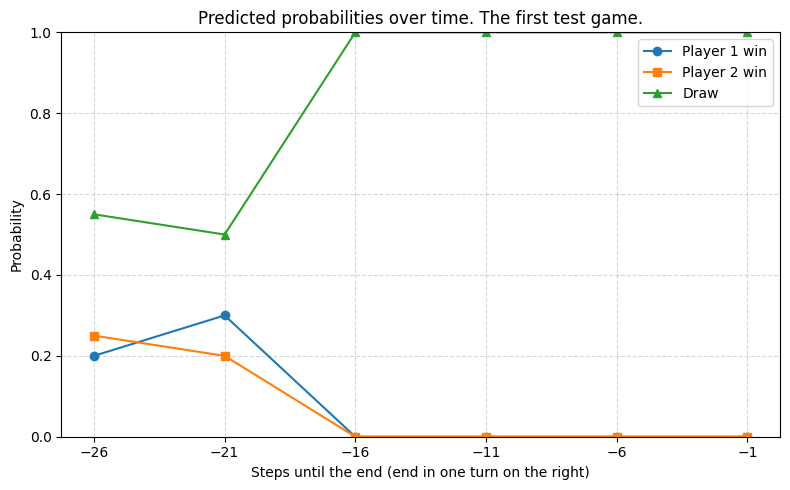

In [100]:
steps = np.arange(-1, -31, -5)

plt.figure(figsize=(8, 5))

plt.plot(steps, player_1_win_pc, marker='o', label='Player 1 win')
plt.plot(steps, player_2_win_pc, marker='s', label='Player 2 win')
plt.plot(steps, draw_pc,          marker='^', label='Draw')

plt.title('Predicted probabilities over time. The first test game.')
plt.xlabel('Steps until the end (end in one turn on the right)')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.xticks(steps)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Regular Predictions Benchmark

In [114]:
outcomes = []
predictions = []
for run in tqdm(test[:20]):
    start, A, B = split_test_run(run)

    # Add blocks to the start
    for event in A:
        if event.stone != 3:
            break
        start.append(event)
        
    outcomes.append(A[-1])
    predictions.append(make_predictions(start))
    

100%|██████████| 20/20 [11:04<00:00, 33.21s/it]


In [117]:
regular_prediction_benchmark = pd.DataFrame({
    'real_outcome': outcomes,
    'player_one_win': [convert_to_float(x['player_one_win']) for x in predictions],
    'player_two_win': [convert_to_float(x['player_two_win']) for x in predictions],
    'draw': [convert_to_float(x['draw']) for x in predictions],
})

In [118]:
regular_prediction_benchmark

,real_outcome,player_one_win,player_two_win,draw
0,draw,0.30,0.25,0.45
1,2,0.00,0.00,1.00
2,draw,0.15,0.10,0.75
3,1,0.40,0.30,0.30
4,1,0.55,0.25,0.20
5,1,1.00,0.00,0.00
6,draw,0.60,0.20,0.20
7,2,0.00,0.00,1.00
8,draw,0.15,0.25,0.60
9,draw,0.60,0.30,0.10


In [120]:
# Calculate baseline based on prior rates, calculated on the train set
train_one_win = 41
train_two_win = 26
train_draws = 33

total = train_one_win + train_two_win + train_draws

train_one_win_pc = train_one_win / total
train_two_win_pc = train_two_win / total
train_draws_pc = train_draws / total

regular_prediction_baseline_benchmark = pd.DataFrame({
    'real_outcome': outcomes,
    'player_one_win': [train_one_win_pc] * len(outcomes),
    'player_two_win': [train_two_win_pc] * len(outcomes),
    'draw': [train_draws_pc] * len(outcomes),
})
regular_prediction_baseline_benchmark

,real_outcome,player_one_win,player_two_win,draw
0,draw,0.41,0.26,0.33
1,2,0.41,0.26,0.33
2,draw,0.41,0.26,0.33
3,1,0.41,0.26,0.33
4,1,0.41,0.26,0.33
5,1,0.41,0.26,0.33
6,draw,0.41,0.26,0.33
7,2,0.41,0.26,0.33
8,draw,0.41,0.26,0.33
9,draw,0.41,0.26,0.33


In [125]:
def calculate_brier_score(benchmark):
    score = 0.0
    for i in range(len(benchmark)):
        outcome = benchmark.iloc[i]['real_outcome']
        if outcome == '1':
            score += (1-benchmark.iloc[i]['player_one_win']) **2
        elif outcome == '2':
            score += (1-benchmark.iloc[i]['player_two_win']) **2
        elif outcome == 'draw':
            score += (1-benchmark.iloc[i]['draw']) **2
        else:
            raise ValueError('Unknown outcome')
    return score / len(benchmark)


In [126]:
print('mini-o4 Brier score:', calculate_brier_score(regular_prediction_benchmark))
print('Prior rates baseline Brier score:', calculate_brier_score(regular_prediction_baseline_benchmark))

mini-o4 Brier score: 0.310125
Prior rates baseline Brier score: 0.42832000000000015


## Counterfactual Prediction

In [144]:
def generate_prompt_cf_prediction(test_run):
    system_prompt = """You are **AlphaGomoku‑o1**, an expert analyst of 7 × 7 Gomoku (win = 4‑in‑a‑row, no wrap‑around).  
You will receive TWO game logs that share the same opening until a branch where blocks were placed differently.

────────────────────────────────────────────────────────────
✦ Input format  
────────────────────────────────────────────────────────────
The message contains two clearly‑marked sections:

### KNOWN_UNIVERSE            ← finished run
GameEvent(row=<int>, col=<int>, stone=<1|2|3>)   ← zero‑indexed  
…(any number of events)…  
### OUTCOME  
Outcome=<1|2|draw>                               ← 1 = P1 win, 2 = P2 win, draw = draw  
(optional) board‑image lines may appear every 5 moves

### ALT_UNIVERSE             ← alternative run (stops at branch point)
GameEvent(row=<int>, col=<int>, stone=<1|2|3>)  
…(events up to the present)…  
(optional) board‑image lines may appear every 5 moves

Notes  
• stone = 1 → black (Player 1) stone = 2 → white (Player 2) stone = 3 → permanent block  
• Turns alternate; blocks do **not** consume a turn.  
• The two logs are identical until the first differing block placement.

────────────────────────────────────────────────────────────
✦ What to do  
────────────────────────────────────────────────────────────
1. Study the KNOWN_UNIVERSE moves.
2. Reconstruct the current board of ALT_UNIVERSE and count empty cells.  
3. Identify tactical features (open‑four, open‑three chains, double threats, etc.).  
4. Determine whose turn is next in ALT_UNIVERSE.  
5. Using perfect‑play reasoning, estimate the probability that **Player 1 wins, Player 2 wins, or the game ends in a draw** from this point forward.  
   • You may use insights from the finished universe as auxiliary evidence (e.g., style, typical mistakes), but your probabilities must reflect the *current* ALT_UNIVERSE board only.  
6. Return your answer in **strict JSON**.
"""
    known_universe = events_to_msg(test_run[0][:-1])
    start, A, B = split_test_run(test_run)
    alternative_events = start
    for event in B:
        if event.stone != 3:
            break
        alternative_events.append(event)
    unknown_universe = events_to_msg(alternative_events)
    user_prompt="### KNOWN_UNIVERSE\n" + known_universe + f"\n### OUTCOME\nOutcome={test_run[0][-1]}\n\n" + "### ALT_UNIVERSE\n" + unknown_universe
    return system_prompt, user_prompt

In [145]:
def make_cf_predictions(test_run):
    system_prompt, user_prompt = generate_prompt_cf_prediction(test_run)
    response = client.responses.create(
        model="o4-mini-2025-04-16",
        input=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        text={
            "format": {
                "type": "json_schema",
                "name": "outcome_prediction",
                "schema": {
                    "type": "object",
                    "properties": {
                        "player_one_win": {
                            "type": "string",
                            "description": "Estimated % probability of player 1 win."
                        },
                        "player_two_win": {
                            "type": "string",
                            "description": "Estimated % probability of player 2 win."
                        },
                        "draw": {
                            "type": "string",
                            "description": "Estimated %probability of a draw."
                        },
                    },
                    "required": ["player_one_win", "player_two_win", "draw"],
                    "additionalProperties": False
                },
                "strict": True
            }
        }
    )
    return json.loads(response.output_text)

In [148]:
results = []
for test_run in tqdm(test[:20]):
    results.append(make_cf_predictions(test_run))

100%|██████████| 20/20 [14:38<00:00, 43.91s/it]


In [149]:
results[0]

{'player_one_win': '55%', 'player_two_win': '35%', 'draw': '10%'}

In [150]:
cf_prediction_benchmark = pd.DataFrame({
    'real_outcome': outcomes,
    'player_one_win': [convert_to_float(x['player_one_win']) for x in results],
    'player_two_win': [convert_to_float(x['player_two_win']) for x in results],
    'draw': [convert_to_float(x['draw']) for x in results],
})
cf_prediction_benchmark

,real_outcome,player_one_win,player_two_win,draw
0,draw,0.55,0.35,0.10
1,2,0.20,0.35,0.45
2,draw,0.15,0.05,0.80
3,1,0.60,0.05,0.35
4,1,0.25,0.15,0.60
5,1,1.00,0.00,0.00
6,draw,0.15,0.05,0.80
7,2,0.30,0.10,0.60
8,draw,0.00,0.00,1.00
9,draw,0.65,0.10,0.25


In [151]:
calculate_brier_score(cf_prediction_benchmark)

np.float64(0.291625)